# What is this report wtf

### Kevin Zhang

Data Science Spring 2017

3/21/2017

#### Documentation/Reference/Works Cited

Data Source:
https://www.start.umd.edu/gtd/

Data Documentation, Variables, Legend:
https://www.start.umd.edu/gtd/downloads/Codebook.pdf

## About this Notebook

This notebook contains all the source code for the data science report done on the question of 

The code below outlines my methodology for gathering, cleaning, and analyzing the data. Basically, I found a dataset from the Global Terrorism database, which is the most comprehensive database that includes virtually all recorded instances of terrorist attacks around the world from the 1970s to present. [insert more discussion of variables and perspective here]

The main concepts used for analysis were [insert stuff here] which were deemed accurate enough for the purposes of this project. 

The overall result is that

For a full breakdown of the code, feel free to continue reading.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import random
import thinkstats2
import thinkplot
import statsmodels.formula.api as smf


In [2]:
def clean_dataframe(df):
    """
    Takes the entire Pandas dataframe and cleans out all bad responses associated with the data that I am specifically
    looking to by replacing them with NaNs. 
    
    Then cleans out nans for usage in regression and other analysis.
    
    Input: Pandas dataframe
    Output: dataframe that has been cleaned out
    """
    df.property.replace([-9], np.nan, inplace=True)
    
    df['propdmg'] = df.property.dropna()
    df['wounded'] = df.nwound.dropna()
    df['fatals'] = df.nkill.dropna()
    
    return df

In [3]:
def make_and_plot_pmf(series, label):
    """
    Takes a category and makes a pmf. Then also plots the pmf using hist.
    
    Input: Category string
    Output: pmf plot
    """
    series_pmf = thinkstats2.Pmf(series, label=label)
    thinkplot.Pmf(series_pmf)
    thinkplot.Config(xlabel=label, ylabel="pmf", loc="upper right")


In [4]:
def calculate_RMSE(endog, r):
    """
    Takes a dependent variables Pandas series and its corresponding coefficient of determination and 
    calculates the RSME of the variable with and without using the regression model
    
    Input: Pandas series, R-value
    Output:RMSE without, RMSE with model
    """
    RMSEraw = endog.std()
    var_ys = RMSEraw**2
    r2 = r
    var_res = (1 - r2) * var_ys
    RMSEmodel = np.sqrt(var_res)
    
    return RMSEraw, RMSEmodel

In [5]:
def OLS_reg(formula, df):
    """
    Takes in a pre-written formula and calculates the Ordinary Least Squares Regression on it
    
    Input: formula string
    Output: OLS regression results summary
    """
    model = smf.ols(formula, data=df)
    results = model.fit()
    return results.summary()
    

This reads in and cleans up the dataset for terrorism, the dataset collected by the Global Terrorism Database from
1970s to present time.

For more information on what each of the variables stand for or how they are evaluated, take a look at the 
Documentation link above

In [6]:
terrorism = pd.read_excel('../../terrorism.xlsx')
terrorism = clean_dataframe(terrorism)

This displays the first 5 rows of the dataframe, for visualization convenience

In [7]:
terrorism.head()

eventid  iyear  imonth  iday approxdate  extended resolution  country  \
0  197000000001   1970       0     0        NaN         0        NaN       58   
1  197000000002   1970       0     0        NaN         0        NaN      130   
2  197001000001   1970       1     0        NaN         0        NaN      160   
3  197001000002   1970       1     0        NaN         0        NaN       78   
4  197001000003   1970       1     0        NaN         0        NaN      101   

          country_txt  region   ...   scite3 dbsource INT_LOG  INT_IDEO  \
0  Dominican Republic       2   ...      NaN     PGIS       0         0   
1              Mexico       1   ...      NaN     PGIS       0         1   
2         Philippines       5   ...      NaN     PGIS      -9        -9   
3              Greece       8   ...      NaN     PGIS      -9        -9   
4               Japan       4   ...      NaN     PGIS      -9        -9   

   INT_MISC  INT_ANY  related propdmg wounded  fatals  
0         0        0      NaN     0.0     0.0     1.0  
1         1        1      NaN     0.0     0.0     0.0  
2         1        1      NaN     0.0     0.0     1.0  
3         1        1      NaN     1.0     NaN     NaN  
4         1        1      NaN     1.0     NaN     NaN  

[5 rows x 140 columns]

### Basic Visualizations

The following graphs are Pmfs of the various variables I will be using, just to visualize what each of them look like
and to potentially gain some insight on each of them

Below is a Pmf of the numbers of deaths in each incident. Note that surprisingly, most incidents resolve without any
fatalities, although some can stretch to over a thousand dead.

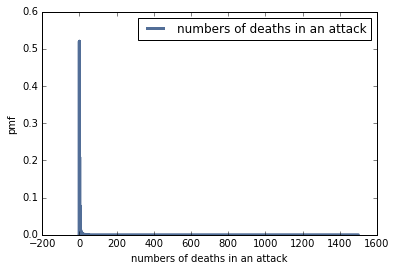

In [8]:
make_and_plot_pmf(terrorism.nkill, "numbers of deaths in an attack")

Below is a Pmf of the numbers of wounded in each incident. Note that surprisingly once again, most incidents resolve without any casualties, although some can stretch to over multiple thousands wounded.

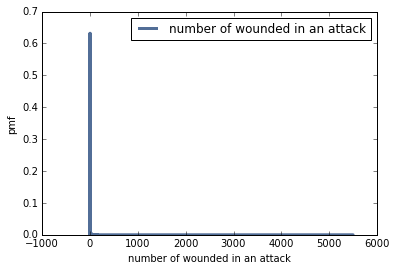

In [9]:
make_and_plot_pmf(terrorism.wounded, "number of wounded in an attack")

Below is a Pmf showing the number of terrorist incident recorded for each country around the globe, where each country
is denoted by a categorical number. Note that the largest peak, number 95, corresponds to Iraq. The US, which is number 217, is actually much smaller in comparison to much of the terrorism incidents that occur around the world.

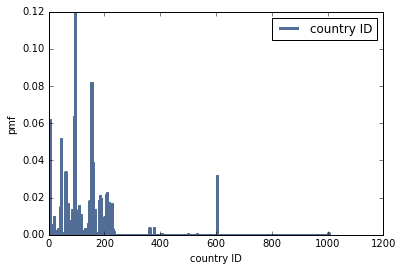

In [10]:
make_and_plot_pmf(terrorism.country, "country ID")

Below is a Pmf showing the showing whether property damage occurred at each incident. Note that for this category, it appears that the distribution favors more property damage, so it seems at first glance that a terrorist incident will likely include some form of property costs because of damage, explosion, etc.

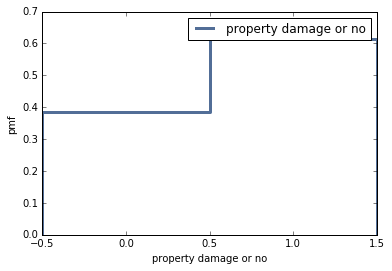

In [11]:
make_and_plot_pmf(terrorism.propdmg, "property damage or no")

Below if a Pmf showing the success of a terrorist incident. Notice that virtually every incident is deemed a success by the database. However, upon reading the documentation, it appears that "success" is considered achieved is something happens at the location of the incident. For example, if the method of attack was a bombing assault, and if one bomb goes off, then that is considered a success, even if the bomb did not damage any property or injure anyone. Because this category is so inclusive, we will not be using in the actual analysis. It is left here to show that it was once considered, but further scrutiny ruled it out.

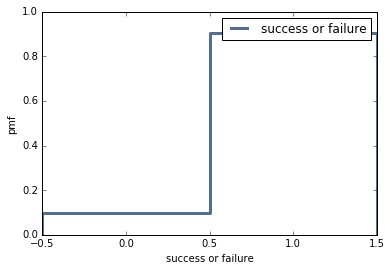

In [12]:
make_and_plot_pmf(terrorism.success, "success or failure")

### Analysis

The following cells show the analysis used in this report. 

First, to measure whether or not the country had any predictive power on the fatality of the incident, I used an OLS regression engine to see if such a correlation existed.

Looking at the results of the regression, the R-squared value is very low, showing little predictive power. The p-values for the countries are all over the place, from being 0 (very statistically significant) to being almost 1 (quite likely to be due to chance). As such, it appears that there death toll from terrorist incidents is not related to the location of where it occurred.

The calculation of the RMSEs with and without the model also proves this idea:

In [13]:
Rwithout, Rwith = calculate_RMSE(terrorism.fatals, .01)
Rwithout, Rwith

(11.421270347657396, 11.364020511717468)

Next, we looked at the wounded count and whether location of the incident had any predictive power on the number of wounded people from an incident. Again, I used OLS regression to see any correlation existed.

Looking at the results of the regression, the R-squared value is even lower this time surprisingly, showing even less little predictive power than for death count. The p-values for the countries are all over the place, from being 0 (very statistically significant) to being almost 1 (quite likely to be due to chance). As such, it appears that terrorist incidents are not region-specific, and two very different locations could have an equally likely chance of experiencing a catastrophic terrorist attack, should one occur.

The calculation of the RMSEs with and without the model also proves this idea:

In [14]:
Rwithout, Rwith = calculate_RMSE(terrorism.wounded, .005)
Rwithout, Rwith

(22.722313053878182, 22.665436085940431)

As a final tidbit, I tried to include more categorical variables as well, such as property damage and success, even whether the country of attack matched the nationality of the target. Unfortunately, for some reason, I received an error that I couldn't resolve no matter what. Looking for hours on the internet, I discovered that a few others have had the exact same problem I had, and that even the statsmodels creators themselves stated that there was no easy fix to the problem. I will include a link to a post I found relevant to this error and lack of solution to this problem. I will show the error for the purposes of documentation, in the hopes that someone else will be able to resolve this someday after me.

Link to problem: http://stackoverflow.com/questions/27413873/statsmodels-logistic-regression-convergence-problems

# Experimentation

14    11727
4      6894
3      6008
2      3853
1      3364
17     1354
15     1142
20     1107
19     1094
7       779
8       727
21      610
10      585
22      373
6       261
18      140
13      130
12      114
16       69
11       46
9        45
Name: targtype1, dtype: int64

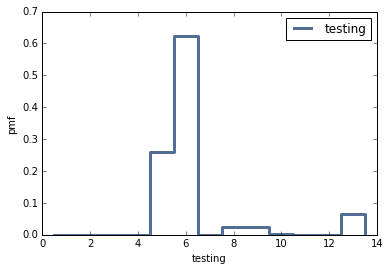

In [15]:
middleEast = terrorism[terrorism.region == 10]
make_and_plot_pmf(middleEast.weaptype1, "testing")
middleEast.targtype1.value_counts()

1     885
14    422
2     410
5     257
3     219
4     208
7     178
8     173
15    117
21    100
10     98
6      54
19     35
12     34
22     17
20     14
18     11
16     10
9       8
11      8
17      8
13      2
Name: targtype1, dtype: int64

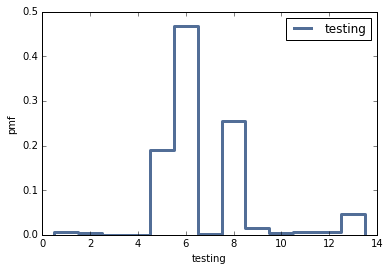

In [16]:
NA = terrorism[terrorism.region == 1]
make_and_plot_pmf(NA.weaptype1, "testing")
NA.targtype1.value_counts()

3290
27


{'xscale': 'linear', 'yscale': 'linear'}

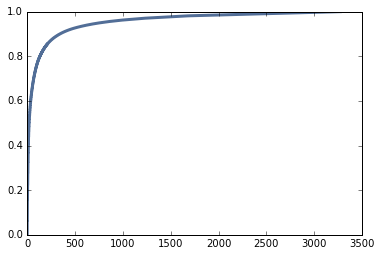

In [46]:
names = terrorism["gname"]
booty = {}
for name in names:
    booty[name] = booty.get(name, 0) + 1
print len(booty)
chick = booty.values()
chick = sorted(chick, reverse=True)
chick = chick[1:]
temp = np.arange(len(chick))
full = zip(temp, chick)
chicken = {}
for rank, freq in full:
    chicken[rank] = freq
pmf = thinkstats2.Pmf(chicken)
cdf = thinkstats2.Cdf(pmf)
print cdf.Percentile(55)
thinkplot.Cdf(cdf)

In [52]:
toplist = []
for name, freq in booty.items():
    toplist.append((name, freq))

toplist = sorted(toplist, reverse=True, key=lambda x: x[1])
print toplist[1:30]

[(u'Taliban', 5502), (u'Shining Path (SL)', 4548), (u'Farabundo Marti National Liberation Front (FMLN)', 3351), (u'Islamic State of Iraq and the Levant (ISIL)', 2833), (u'Irish Republican Army (IRA)', 2670), (u'Revolutionary Armed Forces of Colombia (FARC)', 2474), (u"New People's Army (NPA)", 2241), (u'Al-Shabaab', 2127), (u'Basque Fatherland and Freedom (ETA)', 2024), (u'Boko Haram', 1839), (u"Kurdistan Workers' Party (PKK)", 1782), (u'Communist Party of India - Maoist (CPI-Maoist)', 1666), (u'Liberation Tigers of Tamil Eelam (LTTE)', 1606), (u'National Liberation Army of Colombia (ELN)', 1418), (u'Tehrik-i-Taliban Pakistan (TTP)', 1153), (u'Maoists', 1141), (u'Palestinians', 1124), (u'Nicaraguan Democratic Force (FDN)', 895), (u'Al-Qaida in the Arabian Peninsula (AQAP)', 893), (u'Manuel Rodriguez Patriotic Front (FPMR)', 830), (u'Sikh Extremists', 714), (u'Corsican National Liberation Front (FLNC)', 639), (u'Al-Qaida in Iraq', 635), (u'African National Congress (South Africa)', 606)

In [59]:
worldpop = pd.read_csv('../../worldpop.csv', sep='\t')
worldpop.head()

Country Name Country Code     Indicator Name Indicator Code       1960  \
0        Aruba          ABW  Population, total    SP.POP.TOTL    54208.0   
1      Andorra          AND  Population, total    SP.POP.TOTL    13414.0   
2  Afghanistan          AFG  Population, total    SP.POP.TOTL  8994793.0   
3       Angola          AGO  Population, total    SP.POP.TOTL  5270844.0   
4      Albania          ALB  Population, total    SP.POP.TOTL  1608800.0   

        1961       1962       1963       1964       1965  ...         2007  \
0    55435.0    56226.0    56697.0    57029.0    57360.0  ...     101218.0   
1    14376.0    15376.0    16410.0    17470.0    18551.0  ...      84878.0   
2  9164945.0  9343772.0  9531555.0  9728645.0  9935358.0  ...   25877544.0   
3  5367287.0  5465905.0  5565808.0  5665701.0  5765025.0  ...   19183907.0   
4  1659800.0  1711319.0  1762621.0  1814135.0  1864791.0  ...    2970017.0   

         2008        2009        2010        2011        2012        2013  \
0    101342.0    101416.0    101597.0    101936.0    102393.0    102921.0   
1     85616.0     85474.0     84419.0     82326.0     79316.0     75902.0   
2  26528741.0  27207291.0  27962207.0  28809167.0  29726803.0  30682500.0   
3  19842251.0  20520103.0  21219954.0  21942296.0  22685632.0  23448202.0   
4   2947314.0   2927519.0   2913021.0   2904780.0   2900247.0   2896652.0   

         2014        2015  2016  
0    103441.0    103889.0   NaN  
1     72786.0     70473.0   NaN  
2  31627506.0  32526562.0   NaN  
3  24227524.0  25021974.0   NaN  
4   2893654.0   2889167.0   NaN  

[5 rows x 61 columns]

In [67]:
country = worldpop[worldpop['Country Name']=='United States']
country

Country Name Country Code     Indicator Name Indicator Code  \
248  United States          USA  Population, total    SP.POP.TOTL   

            1960         1961         1962         1963         1964  \
248  180671000.0  183691000.0  186538000.0  189242000.0  191889000.0   

            1965  ...          2007         2008         2009         2010  \
248  194303000.0  ...   301231207.0  304093966.0  306771529.0  309346863.0   

            2011         2012         2013         2014         2015  2016  
248  311718857.0  314102623.0  316427395.0  318907401.0  321418820.0   NaN  

[1 rows x 61 columns]